In [216]:
import numpy as np
from numpy.testing import assert_allclose

import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import edrixs
from solvers import ed_1v1c_py, rixs_1v1c_py
from manybody_operator_csr import two_fermion_csr, four_fermion_csr

from scipy.linalg import solve_banded
from scipy.sparse.linalg import aslinearoperator

#%matplotlib inline

# Run a calcuation using the regular python solver
The regular function `ed_1v1c_py` is modified to return various useful information

## required info
$H$ is `hmat` --- sparse initial state Hamiltonian

$\widetilde{H}$ is `hmat_int` --- sparse intermediate state Hamiltonian


## values for dense calculation and checks
$E_i$ is `eval_i_all` --- all initial state eignevalues

$\ket{i}$ is `evec_i_all` --- all initial state eignevectors

$E_n$ is `eval_n_all` --- all intermediate state eignevalues

$\ket{n}$ is `evec_n_all` --- all intermediate state eignevectors

In [217]:
shell_name = ('d', 'p')
v_noccu=8
slater = ([0.0, 12.234, 7.598],
          [0.0, 12.234, 7.598, 0.0, 7.721, 5.787, 3.291])

c_soc = 11.507
v_soc=(0.05,0.09)

shell_level = (0, -886.5)
info_shell = edrixs.info_atomic_shell()

v_cfmat = edrixs.cf_cubic_d(1.07)

eval_i_all, evec_i_all, eval_n_all, evec_n_all, trans_op, basis_i, basis_n, hmat, hmat_int, ntot = ed_1v1c_py(shell_name, shell_level=shell_level, c_soc=c_soc,
                                      v_noccu=v_noccu, v_cfmat = v_cfmat, v_soc = v_soc, slater=slater,csr=True)

temperature = 300  # in K

ominc = [853]
eloss = np.arange(-1, 5, 0.01)

gamma_c = 0.5
gamma_f = 0.05
thin = np.deg2rad(30)
thout = np.deg2rad(30)
phi = 0
pol_type = [('linear', 0, 'linear', 0)] #, ('linear', 0, 'linear', np.pi/2)]
assert len(pol_type) == 1, "Code implemented for "
gs_list = [0, 1, 2]

rixs_map = rixs_1v1c_py(eval_i_all, eval_n_all, trans_op, ominc, eloss,
                 gamma_c=gamma_c, gamma_f=gamma_f, thin=thin, thout=thout, phi=phi,
                 pol_type=pol_type, gs_list=gs_list,temperature=temperature)
rixs = rixs_map.sum((-3, -1))

# Start Krylov implementation

Obtain a handful of the eigenvectors of the ground state Hamiltonian 
$$
{\cal H} \ket{i} = E_i \ket{i}
$$

In [252]:
# Krylov subspace methods hate exact degeneracies in the ground state
# Block methods, e.g. LOBPCG tend to be more robust, but occasionally fail to converge

#eval_i, evec_i = scipy.sparse.linalg.eigsh(hmat, k=len(gs_list), which="SA",v0=np.random.rand(hmat.shape[0]))

X0 = np.random.rand(hmat.shape[0], 3)
eval_i, evec_i = scipy.sparse.linalg.lobpcg(hmat, X0, largest=False, tol=1e-9, maxiter=200 )

np.testing.assert_allclose(eval_i_all[:len(gs_list)], eval_i[:len(gs_list)], rtol=1e-10, atol=1e-12)

Generate the absorption and emission operators `Di_ylm` and `Df_ylm` in single particle $Y^l_m$ basis

In [239]:
Top_ylm = edrixs.get_trans_oper(shell_name[0] + shell_name[1])

ei, ef = edrixs.dipole_polvec_rixs(thin, thout, phi, pol_type[0][1], pol_type[0][3])
Di_ylm = sum(T*i for T, i in zip(Top_ylm, ei)) # Presumably this is correct although there is probably a better way to program this
Df_ylm = sum(T*i for T, i in zip(Top_ylm, ef))

Create the absoprtion operator ${\cal D}_{\boldsymbol{k},\hat{\epsilon}}$ in the fock basis `Di`

In [240]:
v_norb = info_shell[shell_name[0]][1]
c_norb = info_shell[shell_name[1]][1]
#ncfg_i, ncfg_n = len(basis_i), len(basis_n)


tmp = np.zeros((ntot, ntot), dtype=complex)

tmp[0:v_norb, v_norb:ntot] = Di_ylm
Di = two_fermion_csr(tmp, basis_n, basis_i)

tmp[0:v_norb, v_norb:ntot] = Df_ylm
Df = two_fermion_csr(tmp, basis_n, basis_i)

Compute
$$
\ket{b_i} = {\cal D}_{\boldsymbol{k},\hat{\epsilon}} \ket{i}.
$$

Solve the following linear equation, involving the intermediate state Hamiltontian ${\cal \widetilde{H}}$ via sparse [MINRES](https://en.wikipedia.org/wiki/Minimal_residual_method) methods

$$
\left({\cal \widetilde{H}} - E_i - \hbar\omega_{\boldsymbol{k}}+i\Gamma_c\right) \ket{x_i} = \ket{b_i}
$$

In [241]:
bvec=np.array([Di @ evec_i[:,i] for i in np.arange(len(gs_list))])
xvec= np.zeros([len(gs_list),len(bvec[0])],dtype=complex)
for q in range(len(ominc)):        
    # for all initial states kept:
    for l in range(len(bvec)):
        # this function defines the matrix-vector product applied to a vector x;
        # Iterative methods typically need this function (only) instead of storing the full matrix.
        def matvec(x):
            return -hmat_int @ x + (ominc[q] + eval_i[l] + 1j*gamma_c) * x
        ApcI = sp.linalg.LinearOperator(shape=hmat_int.shape, matvec=matvec, dtype=hmat_int.dtype)
        
        # solve system (-H_n + \omega + E_i + I*\Gamma_c)|x> = D|\psi_i> for |x>
        # This calculates the action of the inverse inverse operators on the particular vectors we need
        # Since this matrix is not hermitian (explicit I factors in diagonal), we use GMRES
        xvec[l], info_mr = sp.linalg.gmres(ApcI, bvec[l], tol=1e-9,maxiter=50000, restart=200)
        

Apply emission operator

$$
\ket{F_i} = {\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}  \ket{x_i}
$$

In [242]:
Fvec= np.zeros([len(gs_list),len(evec_i)],dtype=complex)
for l in range(len(xvec)):
    Fvec[l] = Df.getH() @ xvec[l]

* The spectrum can then be represented as

$$
I \propto -\sum_{i}e^{- E_{i}/(k_\mathrm{B}T)} \Im \bra{F_i} \frac{1}{{\cal H} - E_i - \hbar\omega_{\boldsymbol{q}}+i \Gamma} \ket{F_i}
$$

* The continued fraction technique is then used to construct the spectrum


In [243]:
def lanczos_tridiagonal(H, v0, m):
    H = aslinearoperator(H)
    n = H.shape[0]
    v = v0 / np.linalg.norm(v0)
    
    alphas = np.zeros(m, dtype=float)
    betas  = np.zeros(m-1, dtype=float)

    w = H @ v
    alphas[0] = np.vdot(v, w).real
    w = w - alphas[0] * v

    for j in range(1, m):
        betas[j-1] = np.linalg.norm(w)
        if betas[j-1] == 0:
            # lucky breakdown: actual Krylov dimension < m
            return alphas[:j], betas[:j-1]
        v_old = v
        v = w / betas[j-1]
        w = H @ v - betas[j-1] * v_old
        alphas[j] = np.vdot(v, w).real
        w = w - alphas[j] * v

    return alphas, betas
def resolvent_from_tridiag(alphas, betas, C, norm_psi):
    # Build banded form for T + C I
    m = len(alphas)
    # upper, diagonal, lower
    ab = np.zeros((3, m), dtype=complex)
    ab[1, :] = alphas + C          # main diagonal
    ab[0, 1:] = betas              # upper diag
    ab[2, :-1] = betas             # lower diag

    e1 = np.zeros(m, dtype=complex)
    e1[0] = 1.0

    y = solve_banded((1, 1), ab, e1)
    return norm_psi**2 * y[0]
def build_lanczos_resolvent(H, psi, m):
    norm_psi = np.linalg.norm(psi)
    v0 = psi / norm_psi
    alphas, betas = lanczos_tridiagonal(H, v0, m)
    def g(C):
        return resolvent_from_tridiag(alphas, betas, C, norm_psi)
    return g

In [244]:
g = [build_lanczos_resolvent(hmat, Fvec[l], m=200) for l in range(len(Fvec))]
prob = edrixs.boltz_dist(eval_i, temperature)

In [246]:
evlist=[[-prob[j]*g[j](-eval_i[j]-eloss[i]+1j*gamma_f).imag for i in range(len(eloss))] for j in range(len(eval_i))]
evlist=np.array(evlist).sum(axis=0)

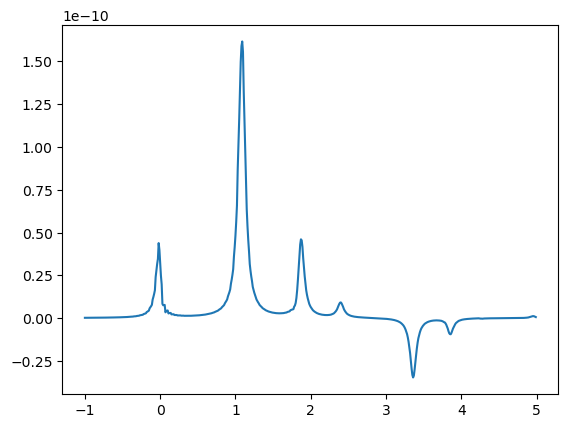

In [253]:
plt.plot(eloss,rixs-evlist/np.pi)
#plt.plot(eloss,rixs)
#plt.plot(eloss,evlist/np.pi)